[*********************100%%**********************]  1 of 1 completed
d:\Apps\Anaconda\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Apps\Anaconda\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	10    
1  	8     
2  	7     
3  	6     
4  	9     
5  	7     
Best Fast Moving Average Window is: 57, Best Slow Moving Average Window is: 85


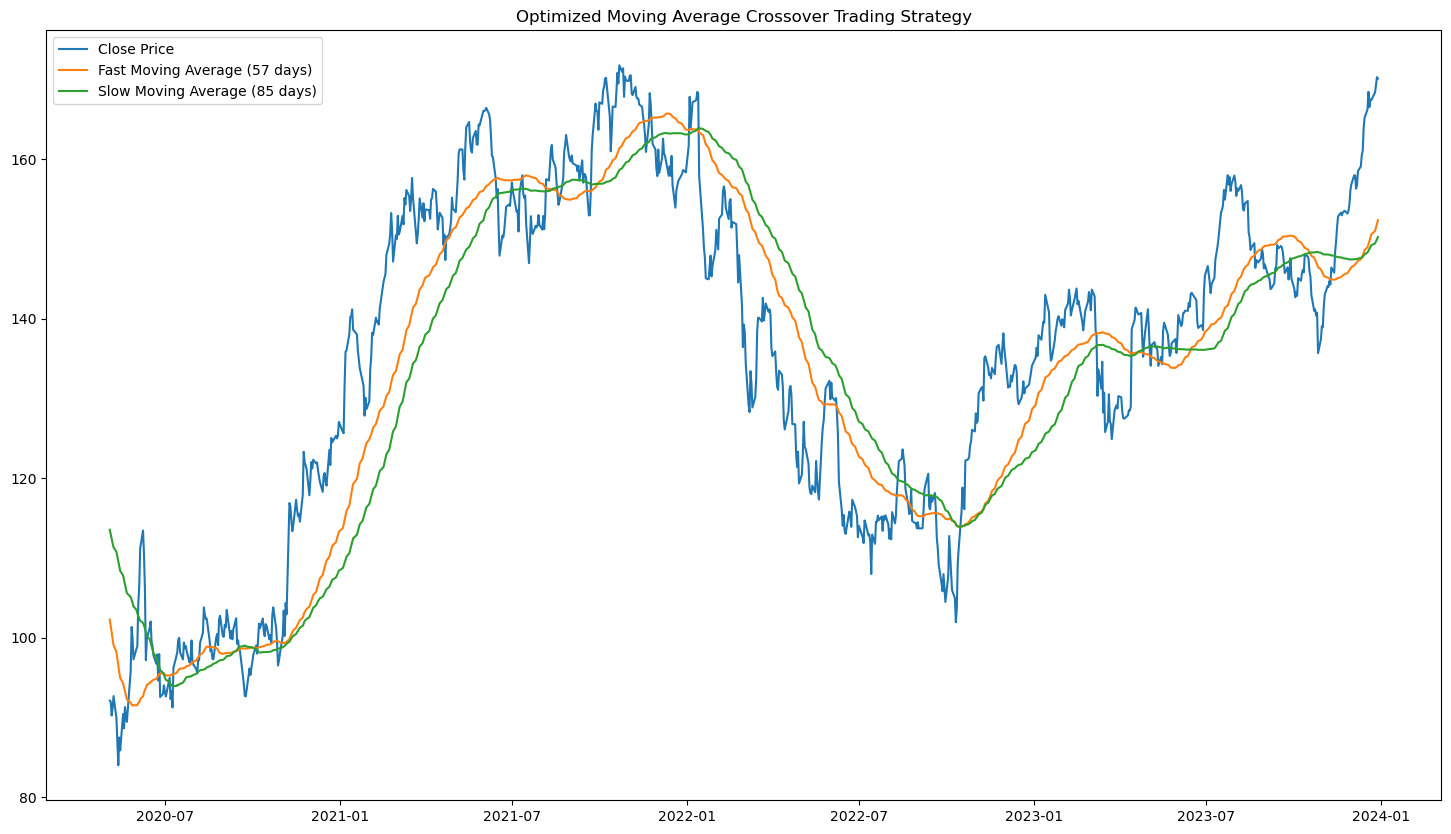

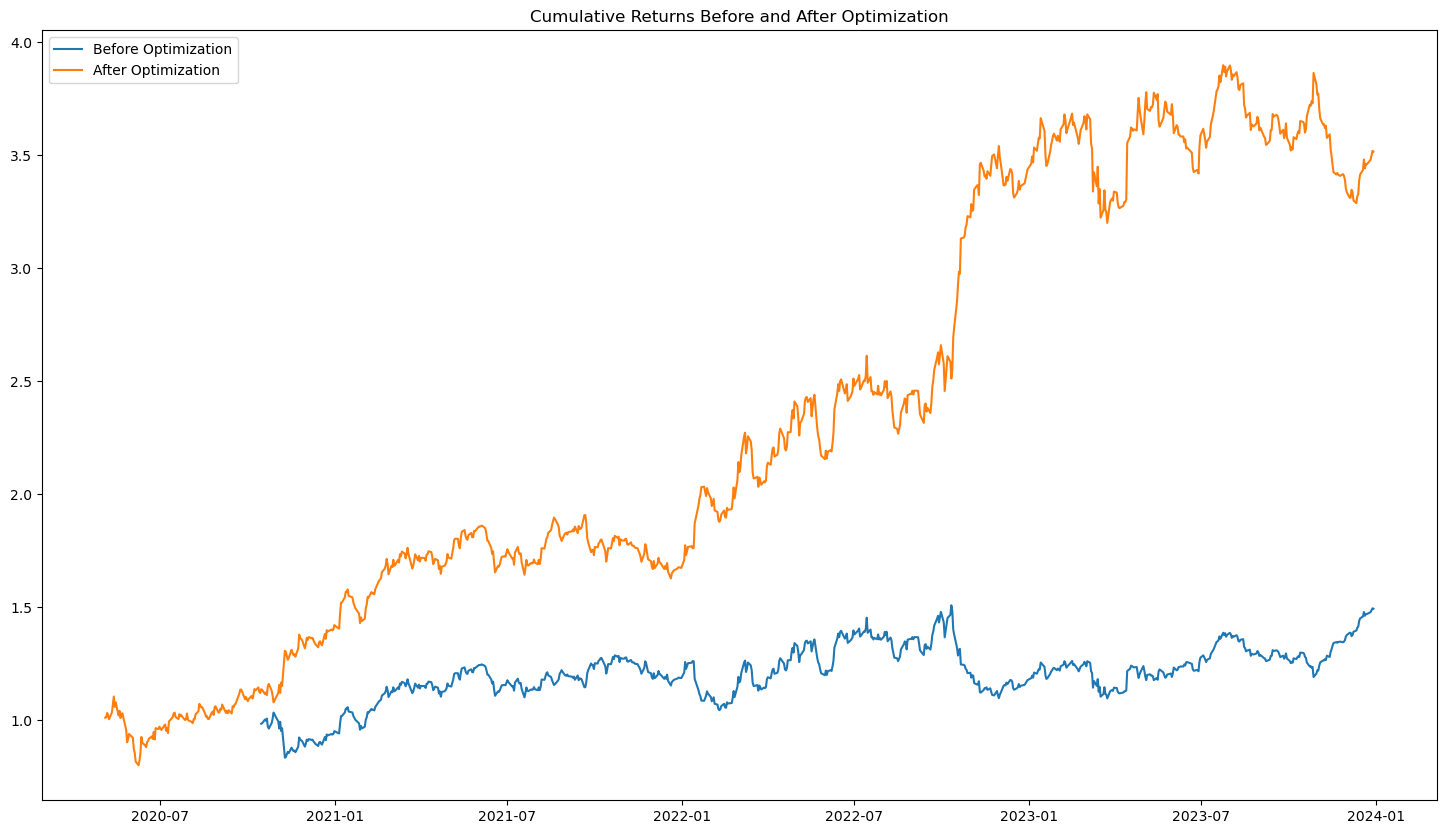

In [15]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# JPM (JPMorgan Chase & Co.) historical security price data
ticker = 'JPM'
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')
df = pd.DataFrame(data)
df.to_csv('JPM.csv')

# Calculate moving average
def calculate_moving_averages(data, fast_window, slow_window):
    data['Fast_MA'] = data['Close'].rolling(window=fast_window).mean()
    data['Slow_MA'] = data['Close'].rolling(window=slow_window).mean()
    data['Signal'] = np.where(data['Fast_MA'] > data['Slow_MA'], 1, -1)
    data['Return'] = data['Signal'] * data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

# Define the objective function (maximize cumulative revenue)
def evaluate_strategy(individual):
    fast_window, slow_window = individual
    data_copy = data.copy()
    data_copy = calculate_moving_averages(data_copy, int(fast_window), int(slow_window))
    cumulative_return = (1 + data_copy['Return']).cumprod().iloc[-1]
    return cumulative_return,

# Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 10, 100)  # 移动平均线窗口大小的取值范围
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_strategy)

# Create a population
population = toolbox.population(n=10)
generation, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=5, stats=None, halloffame=None)

# Obtain the best individual
best_individual = tools.selBest(population, k=1)[0]
best_fast_window, best_slow_window = best_individual

# Output the optimal parameters
print(f"Best Fast Moving Average Window is: {best_fast_window}, Best Slow Moving Average Window is: {best_slow_window}")

# Recalculate moving average
data_optimized = calculate_moving_averages(data.copy(), int(best_fast_window), int(best_slow_window))
plt.figure(figsize=(18, 10))
plt.plot(data_optimized['Close'], label='Close Price')
plt.plot(data_optimized['Fast_MA'], label=f'Fast Moving Average ({int(best_fast_window)} days)')
plt.plot(data_optimized['Slow_MA'], label=f'Slow Moving Average ({int(best_slow_window)} days)')
plt.title('Optimized Moving Average Crossover Trading Strategy')
plt.legend()
plt.show()


data_before_optimization = calculate_moving_averages(data.copy(), 50, 200)
cumulative_return_before_optimization = (1 + data_before_optimization['Return']).cumprod()

data_optimized = calculate_moving_averages(data.copy(), int(best_fast_window), int(best_slow_window))
cumulative_return_optimized = (1 + data_optimized['Return']).cumprod()

# Comparison chart of cumulative returns before and after optimization
plt.figure(figsize=(18, 10))
plt.plot(cumulative_return_before_optimization, label='Before Optimization')
plt.plot(cumulative_return_optimized, label='After Optimization')
plt.title('Cumulative Returns Before and After Optimization')
plt.legend()
plt.show()
